Import des libraires

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob

# Import du jeu de données

In [4]:
files_to_load = glob.glob('../data/*.txt')
dvf_raw = pd.concat([pd.read_csv(file,sep="|", decimal=',') for file in files_to_load])
df_reference_departement_raw = pd.read_csv("../reference/departements-region.csv",delimiter=",")

C:\Users\maelp\AppData\Local\Temp\ipykernel_10532\1324177573.py:2: DtypeWarning: Columns (18,23,24,26,28,41) have mixed types. Specify dtype option on import or set low_memory=False.
  dvf_raw = pd.concat([pd.read_csv(file,sep="|", decimal=',') for file in files_to_load])


# purification des données

In [5]:
dvf_raw['Date mutation'] = pd.to_datetime(dvf_raw['Date mutation'], format='%d/%m/%Y')
dvf_raw['Nature mutation'] = dvf_raw['Nature mutation'].astype('category')

colonnes_a_garder = [
    'Date mutation', 
    'Nature mutation', 
    'Valeur fonciere',
    'Commune',
    'Code departement',
    'Surface terrain',
    'Surface reelle bati'
    ]

df_vf_raw = dvf_raw.drop(columns=[col for col in dvf_raw.columns if col not in colonnes_a_garder])
pd.set_option('display.float_format', '{:.2f}'.format)

### Aout d'un zéro ddans le code département pour Merger

In [6]:
def updateCode(code : object) -> str:
    return str.zfill("{0}".format(code),2)

dvf_raw['Code departement']=dvf_raw['Code departement'].apply(updateCode)

df_dvf_region = dvf_raw.merge(df_reference_departement_raw, how='left',left_on='Code departement', right_on='num_dep')

In [7]:
df_dvf_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3803885 entries, 0 to 3803884
Data columns (total 46 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Identifiant de document     float64       
 1   Reference document          float64       
 2   1 Articles CGI              float64       
 3   2 Articles CGI              float64       
 4   3 Articles CGI              float64       
 5   4 Articles CGI              float64       
 6   5 Articles CGI              float64       
 7   No disposition              int64         
 8   Date mutation               datetime64[ns]
 9   Nature mutation             category      
 10  Valeur fonciere             float64       
 11  No voie                     float64       
 12  B/T/Q                       object        
 13  Type de voie                object        
 14  Code voie                   object        
 15  Voie                        object        
 16  Code postal       

In [27]:
#dvf_region_1 = df_dvf_region.loc[(df_dvf_region['Nature mutation']== 'Vente') & df_dvf_region['Code departement'] == '01']
#dvf_region_1['Valeur fonciere'].mean()

moyenne_prix_departement = df_dvf_region.groupby('Code departement')['Valeur fonciere'].mean()
nombre_vente_departement = df_dvf_region.groupby('Code departement')['Valeur fonciere'].count()
nom_departement = df_dvf_region.groupby('Code departement')['dep_name']

# Affichage du résultat
#print(moyenne_prix_departement)
#print(nombre_vente_departement)

fusion_prix_moyen_nb_vente = pd.merge(moyenne_prix_departement, nombre_vente_departement, left_index=True, right_index=True)
fusion.rename(columns={"Valeur fonciere_x": "moyenne_prix", "Valeur fonciere_y": "nombre_vente"},inplace=True)
#fusion.reset_index(inplace=True)

In [15]:
colonne_tri = 'moyenne_prix'
df_trie = fusion.sort_values(by=colonne_tri)[:5]
print(df_trie)


   Code departement  moyenne_prix  nombre_vente  dep_name
21               23      85905.16         15009     15299
55               55      87403.05         11816     11821
43               43      96703.16         20718     20839
67               70     112698.57         18434     18462
14               15     115300.03         13430     13475


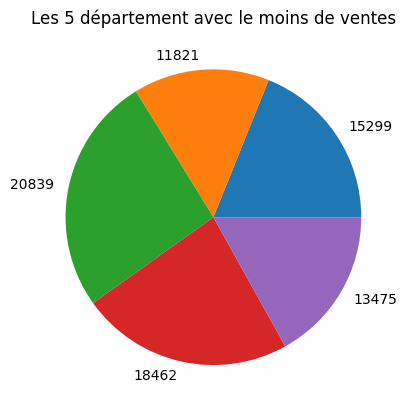

In [29]:
plt.pie(df_trie['nombre_vente'],labels =df_trie['dep_name'])

# Ajouter un titre
plt.title('Les 5 département avec le moins de ventes')
# Afficher le diagramme
plt.show()